# Resource
- [airbnb dashboard for taipei](http://insideairbnb.com/taipei/?neighbourhood=&filterEntireHomes=false&filterHighlyAvailable=false&filterRecentReviews=false&filterMultiListings=false)
- [data source](http://insideairbnb.com/get-the-data.html)  
 **calendar csv file format error**

# Note
airbnb use dynamic pricing, according to times of being searched..etc. Thus there's some exogenous infomation affect the price

# Analysis topic ideate pool
- price prediction
- geo location
- calendar(X)
- geo dbscan

Right... the data is limited. I'm gonna stick with price prediction. And focus more on when would the machine make mistake

In [27]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
os.listdir("../../data/raw/")

['listings.csv.gz',
 'calendar.csv.gz',
 'reviews.csv',
 '.DS_Store',
 'neighbourhoods.geojson',
 'reviews.csv.gz',
 'neighbourhoods.csv',
 'listings.csv',
 'reviews_detail.csv',
 'listings_detail.csv']

In [8]:
# # duplicated with listing detail
# listing_summary = pd.read_csv("../../data/raw/listings.csv")
# listing_summary.head()

In [9]:
listing_detail = pd.read_csv("../../data/raw/listings_detail.csv")
listing_detail.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,178036,https://www.airbnb.com/rooms/178036,20201231072412,2020-12-31,單人床位 Single bunk bed [mixed dorm for 4pax],Hello from Taipei :)<br />We are located at Z...,Local food within 5 mins walk<br />6 mins walk...,https://a0.muscache.com/pictures/1263b356-1513...,851825,https://www.airbnb.com/users/show/851825,...,10.0,10.0,10.0,NaN,t,9,0,1,1,0.71
1,271733,https://www.airbnb.com/rooms/271733,20201231072412,2021-01-01,Taipei Rooftop - Whole apartment!,"Yes! You get the whole apartment. It's nice, i...",A family neighborhood -- very quiet and safe. ...,https://a0.muscache.com/pictures/8824698/31a49...,242033,https://www.airbnb.com/users/show/242033,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.58
2,289296,https://www.airbnb.com/rooms/289296,20201231072412,2021-01-01,Fabulous studio - Center Taipei-- Monthly only,"Zhongxiao East Road, Daan District<br /><br />...",NaN,https://a0.muscache.com/pictures/57880667/43e7...,1338052,https://www.airbnb.com/users/show/1338052,...,10.0,10.0,9.0,NaN,f,3,3,0,0,0.34
3,289298,https://www.airbnb.com/rooms/289298,20201231072412,2021-01-03,Fabulous Studio in heart of Taipei----Monthly ...,"Elite area in Dazhi, Zhongshan District.<br />...",NaN,https://a0.muscache.com/pictures/cca653f0-6815...,1338052,https://www.airbnb.com/users/show/1338052,...,10.0,10.0,9.0,NaN,f,3,3,0,0,1.96
4,310542,https://www.airbnb.com/rooms/310542,20201231072412,2021-01-01,"TMP Co-Living,long term+monthly rental+Not daily",台北居大不易(夭壽貴)?<br />回家覺得空虛寂寞覺得冷??<br />下班後沒人一起吃飯...,便利交通<br /><br />→ 步行松山車站只要3分鐘／捷運松山站5分鐘／捷運後山埤站6...,https://a0.muscache.com/pictures/06496984-ed90...,1597675,https://www.airbnb.com/users/show/1597675,...,9.0,8.0,9.0,NaN,f,8,0,0,8,0.18


Let do some grouping  

- host upload info  
'name','description', 'neighborhood_overview', 'picture_url'

- host info  
'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
'host_about', 'host_response_time', 'host_response_rate',
'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
'host_picture_url', 'host_neighbourhood', 'host_listings_count',
'host_total_listings_count', 'host_verifications',
'host_has_profile_pic', 'host_identity_verified'

- host stats (這個房東有幾個listing)  
'calculated_host_listings_count',
'calculated_host_listings_count_entire_homes',
'calculated_host_listings_count_private_rooms',
'calculated_host_listings_count_shared_rooms',

- house geo  
'neighbourhood', (neighboring area, list of categories)
'neighbourhood_cleansed',
'latitude', 'longitude', 

- house condition  
'property_type', 'room_type', 
'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
'amenities'(list of 設備們)

- offer  
'price', 'minimum_nights', 'maximum_nights',
'minimum_minimum_nights', 'maximum_minimum_nights',
'minimum_maximum_nights', 'maximum_maximum_nights',
'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
'instant_bookable',

- reserved status  
'has_availability', 'availability_30',
'availability_60', 'availability_90', 'availability_365',

- reviews stats  
 'number_of_reviews',
'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
'last_review', 'review_scores_rating', 'review_scores_accuracy',
'review_scores_cleanliness', 'review_scores_checkin',
'review_scores_communication', 'review_scores_location',
'review_scores_value', 'reviews_per_month'

- useless  
'neighbourhood_group_cleansed'(all nan)  
'calendar_updated' (all nan)  
'calendar_last_scraped'(最後抓取時間)  
'license' (all nan)  
'id', 'listing_url', 'scrape_id', 'last_scraped', 

In [10]:
import json
with open("../../data/raw/neighbourhoods.geojson") as fp:
    geojson = json.load(fp) # all district polygons

In [11]:
# duplicated with reviews_detail
# review_summary = pd.read_csv("../../data/raw/reviews.csv")
# review_summary.head()

In [12]:
review_detail = pd.read_csv("../../data/raw/reviews_detail.csv")
review_detail.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,178036,407524,2011-07-30,274232,Kurt,"Great location, near an university, young crow..."
1,178036,590835,2011-10-02,1155635,Lukasz,"Great location and great place to stay. Clean,..."
2,178036,677192,2011-10-30,43806,Vic,Great place for a lone traveler on a budget. ...
3,178036,700785,2011-11-07,1224590,Johanis,Easy to reach an close to MRT station. People ...
4,178036,890336,2012-01-30,1506374,Wen,we stayed in Taipei Taipei Hostel for 6 nights...


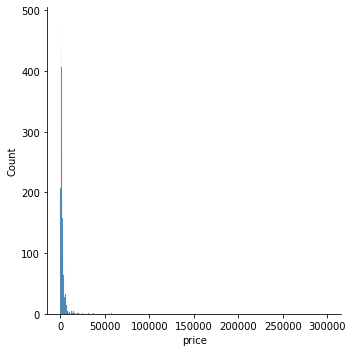

In [30]:
sns.displot(listing_detail['price'].str.replace('[$,]', '').astype(float))